In [1]:
from qiskit.ml.datasets import *
from qiskit import QuantumCircuit
from qiskit.aqua.components.optimizers import COBYLA, ADAM, SPSA, SLSQP, POWELL, L_BFGS_B, TNC, AQGD
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, ZFeatureMap, PauliFeatureMap
from qiskit.quantum_info import Statevector

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# constants
n = 4
RANDOM_STATE = 42
LR = 1e-3
class_labels = ['yes', 'no']

In [3]:
def normalizeData(DATA_PATH = "../../Data/Processed/data.csv"):
    """
    Normalizes the data
    """
    # Reads the data
    data = pd.read_csv(DATA_PATH)
    data = shuffle(data, random_state=RANDOM_STATE)
    X, Y = data[['sex', 'cp', 'exang', 'oldpeak']].values, data['num'].values
    # normalize the data
    X = normalize(X)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE)
    return X_train, X_test, Y_train, Y_test

In [4]:
X_train, X_test, Y_train, Y_test = normalizeData()

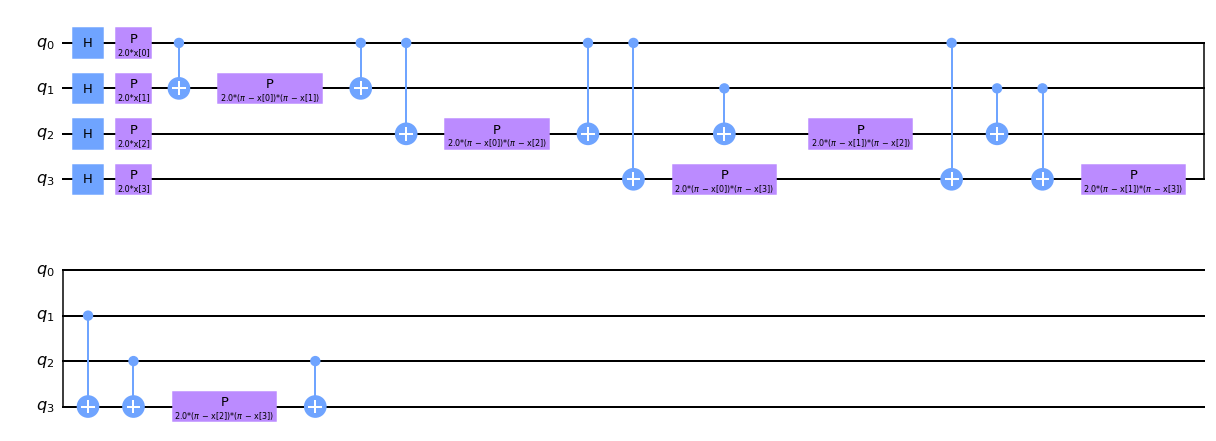

In [5]:
feature_map = ZZFeatureMap(n, reps=1)
feature_map.draw(output="mpl", filename="../../Output/Figures/ZZFeaturemap.png")

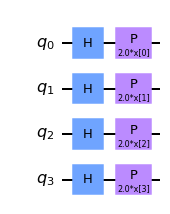

In [6]:
feature_map = ZFeatureMap(n, reps=1)
feature_map.draw(output="mpl", filename="../../Output/Figures/ZFeaturemap.png")

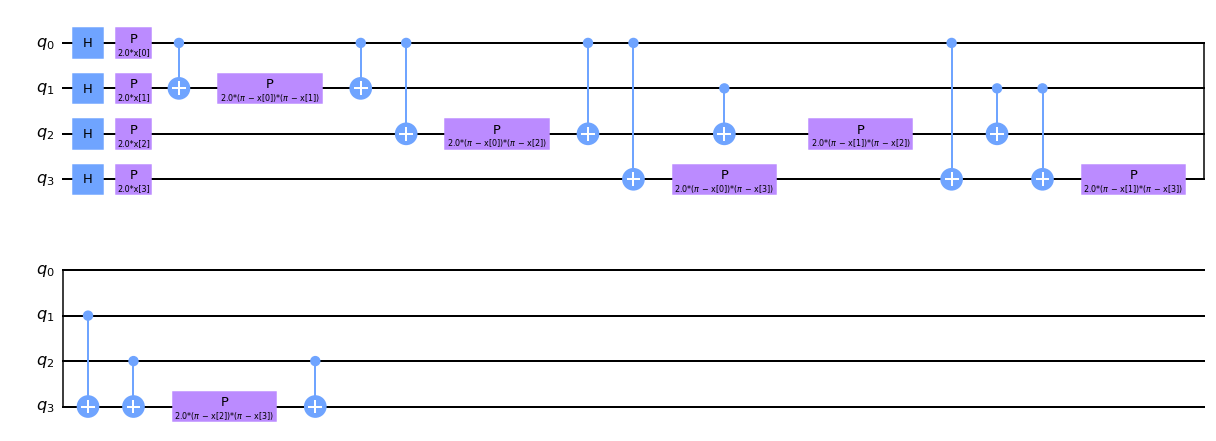

In [7]:
feature_map = PauliFeatureMap(n, reps=1)
feature_map.draw(output="mpl", filename="../../Output/Figures/PauliFeaturemap.png")

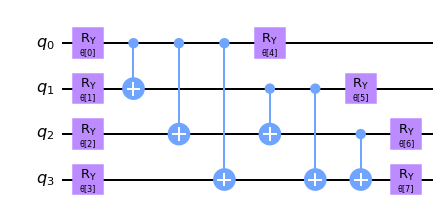

In [8]:
var_form = RealAmplitudes(n, reps=1)
var_form.draw(output="mpl", filename="../../Output/Figures/RealAmplitudes.png")

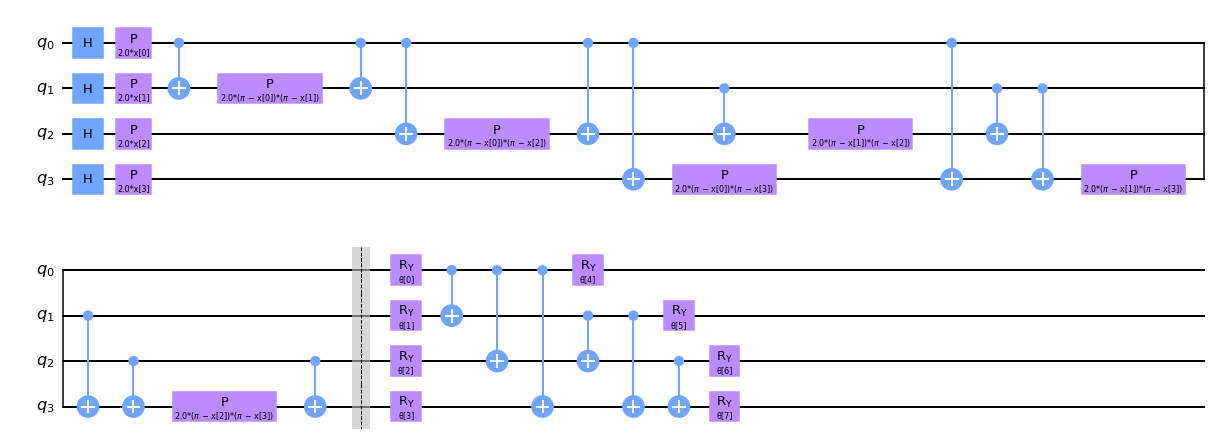

In [9]:
sv = Statevector.from_label('0' * n)
feature_map = ZZFeatureMap(n, reps=1)
feature_map.barrier()
var_form = RealAmplitudes(n, reps=1)
circuit = feature_map.combine(var_form)
circuit.draw(output="mpl", filename="../../Output/Figures/overallcircuit.png")

In [10]:
def get_data_dict(params, x):
    parameters = {}
    for i, p in enumerate(feature_map.ordered_parameters):
        parameters[p] = x[i]
    for i, p in enumerate(var_form.ordered_parameters):
        parameters[p] = params[i]
    return parameters

In [11]:
def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

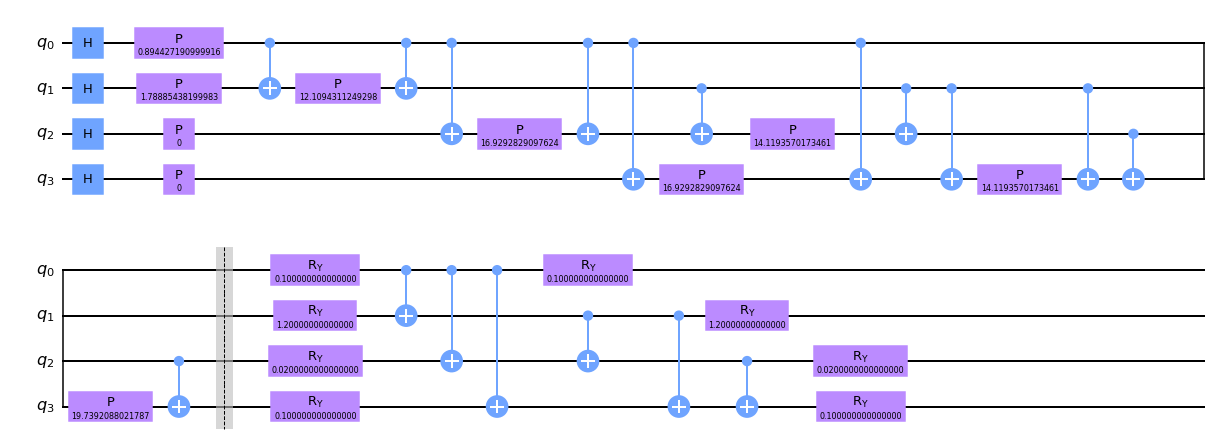

In [12]:
data = X_train[0]
params = np.array([0.1, 1.2, 0.02, 0.1, 0.1, 1.2, 0.02, 0.1])
circ_ = circuit.assign_parameters(get_data_dict(params, data))
circ_.draw(plot_barriers=True, output="mpl", filename="../../Output/Figures/parameterisedcircuit.png")